In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 100,
})

import numpy as np

rng = np.random.default_rng()

# Hexagonal arena

Position inside arena will be discretized according to a hexagonal grid.

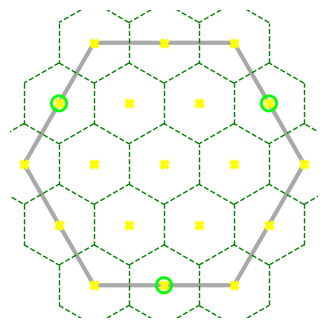

In [2]:
from hexarena.arena import Arena

arena = Arena(2)
fig, ax = plt.subplots(figsize=(4, 4))
arena.plot_mesh(ax)
fig.savefig('figures/arena-map.png', bbox_inches='tight')

# Foodbox

An example of volatile box is shown, with the box quality switching randomly.

Box with taus: (35, 21, 15) run for 120 steps with no push


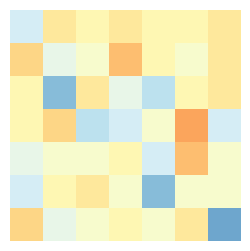

In [3]:
from hexarena.box import VolatileBox

box = VolatileBox(taus=[35, 21, 15], num_grades=20, num_patches=49)
box.reset()

fig, ax = plt.subplots(figsize=(3, 3))
h = ax.imshow(box.colors, vmin=-1, vmax=box.num_grades, cmap='RdYlBu_r')
ax.set_axis_off()

def init():
    box.reset()
    h.set_data(box.colors)
    return h,

def update(i):
    box.step(0)
    h.set_data(box.colors)
    return h,

num_frames = 120
print('{} run for {} steps with no push'.format(box, num_frames))
ani = FuncAnimation(fig, update, frames=range(num_frames), init_func=init, blit=True)
ani.save('figures/color-cues.gif')

# Foraging environment

Here shows an environment similar to the actual experiment, where three food boxes are set up. Quality of each box is fixed during the experiment, and we use high noise for cue due to the lack of monitor information in the preliminary data.

In [4]:
from hexarena.env import SimilarBoxForagingEnv

env = SimilarBoxForagingEnv(
    box={
        '_target_': 'hexarena.box.StationaryBox', 'num_patches': 25, 'num_levels': 10, 'num_grades': 10, 'sigma': 0.01,
    },
    boxes=[
        {'tau': 5}, {'tau': 20}, {'tau': 80},
    ],
)

## Run an example trial with random policy

In [5]:
from irc.buffer import Episode

states, observations, actions, rewards, infos = [], [], [], [], []
num_steps = 600

observation, info = env.reset()
states.append(env.get_state())
observations.append(observation)
infos.append(info)
for _ in range(num_steps):
    action = env.action_space.sample()
    observation, reward, _, _, info = env.step(action)
    actions.append(action)
    rewards.append(reward)
    states.append(env.get_state())
    observations.append(observation)
    infos.append(info)

episode = Episode(
    num_steps, True,
    np.array(states), np.array(observations), np.array(actions), np.array(rewards),
    infos=infos,
)

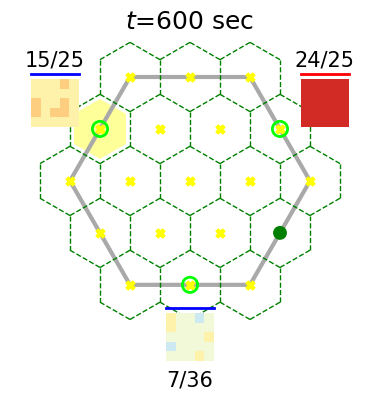

In [6]:
pos, gaze, rewarded, foods, colors, counts, _ = env.convert_episode(episode)

fig, ani = env.play_episode(pos, gaze, rewarded, foods, colors, counts)
ani.save('figures/example-trial.gif', fps=12)